# TIME SERIES RODRIGO



## 1) Descrever a série temporal de acordo com as suas componentes e propriedades. Desde a tendência, sazonalidade, heterocedastidade, entre outros.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
import plotly.graph_objects as go
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsforecast.models import auto_arima
from src.tde import UnivariateTDE


ImportError: cannot import name 'auto_arima' from 'statsforecast.models' (c:\Users\PC\anaconda3\envs\git\lib\site-packages\statsforecast\models.py)

BASE DE DADOS

In [5]:
df = pd.read_csv("energy_load_pt.csv")

In [6]:
df.shape

(13104, 2)

In [7]:
df.head()

,datetime,load
0,2020-11-17 08:00:00,5159.0
1,2020-11-17 09:00:00,4985.0
2,2020-11-17 10:00:00,4717.0
3,2020-11-17 11:00:00,4356.0
4,2020-11-17 12:00:00,4086.0


In [8]:
df.datetime.shape

(13104,)

In [9]:
# existem valores omissos
df.isna().sum()

datetime    0
load        2
dtype: int64

In [10]:
df.load.shape

(13104,)

In [11]:
df.tail()

,datetime,load
13099,2022-05-17 04:00:00,5190.0
13100,2022-05-17 05:00:00,5297.0
13101,2022-05-17 06:00:00,5441.0
13102,2022-05-17 07:00:00,5735.0
13103,2022-05-17 08:00:00,5418.0


<Axes: xlabel='datetime'>

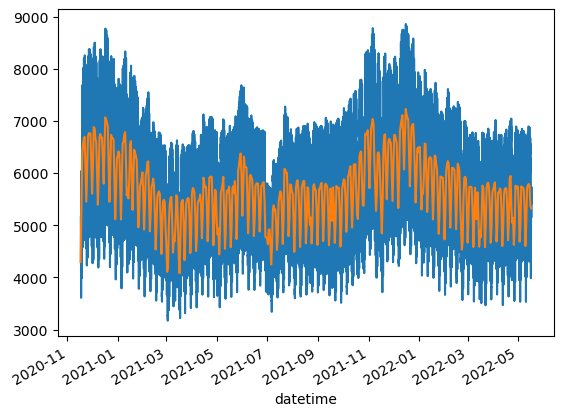

In [16]:
series = pd.Series(df['load'])
series.index = pd.to_datetime(df['datetime'])
series.plot()
series.resample('D').mean().plot()

<Axes: xlabel='datetime'>

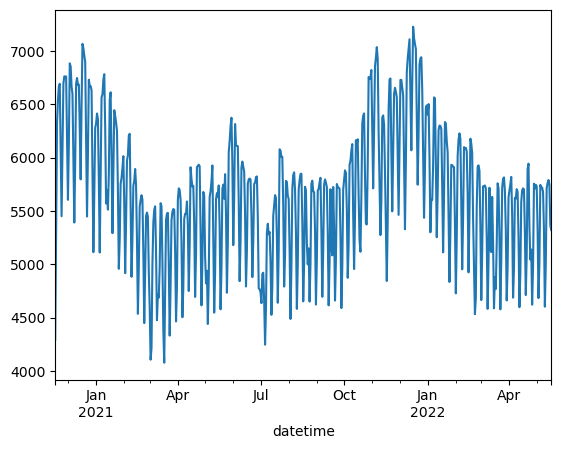

In [17]:
series_d = series.resample('D').mean()
series_d.plot()

<Axes: ylabel='Frequency'>

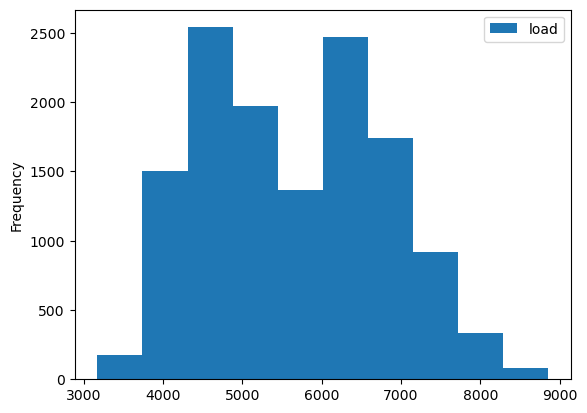

In [18]:
# tem valores extremos
df.plot.hist()

In [19]:
from pmdarima.arima import ndiffs, nsdiffs

# kpss test
ndiffs(series_d, test='kpss')

1

In [20]:
# augmented dickey-fuller
ndiffs(series_d, test='adf')

1

In [21]:
# testes para sazonalidade
nsdiffs(series_d, test='ocsb', m=30)

0

In [22]:
nsdiffs(series_d, test='ch', m=30)

0

<Axes: xlabel='datetime'>

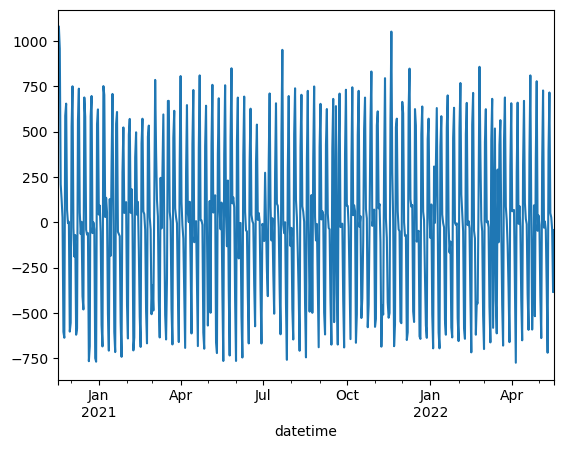

In [23]:
# removendo a tendencia
series_d.diff(periods=1).plot()

<Axes: xlabel='datetime'>

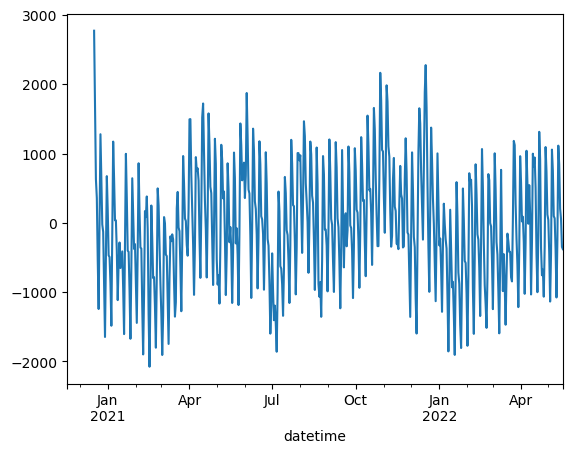

In [24]:
# removendo a sazonalidade
series_d.diff(periods=30).plot()

<Axes: xlabel='datetime'>

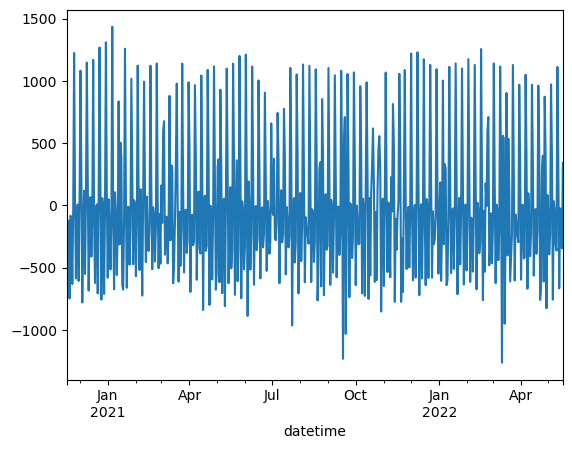

In [25]:
# residuos
series_d.diff(periods=1).diff(periods=1).plot()

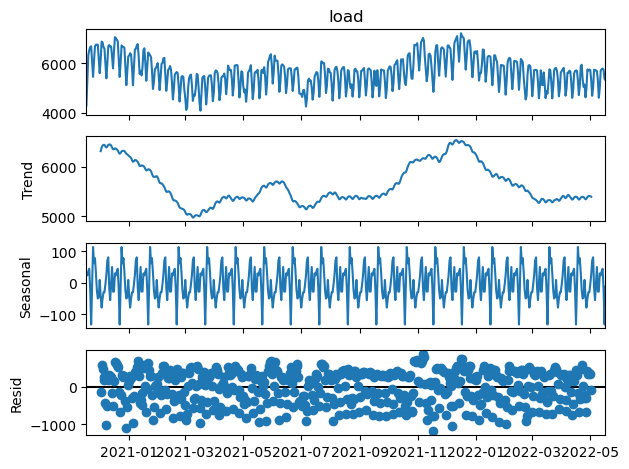

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(series_d,
                            model='additive',
                            period=30)

plt = result.plot()


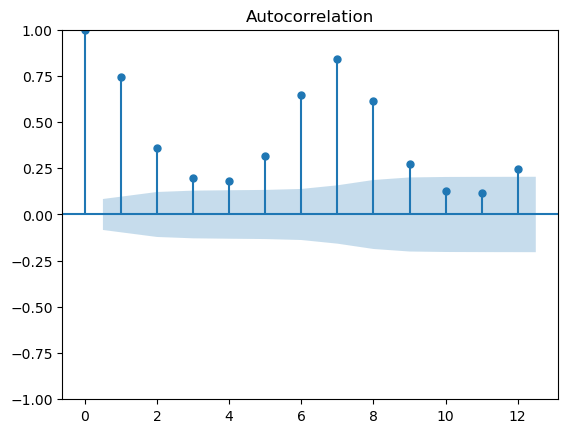

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt = plot_acf(series_d, lags=12)

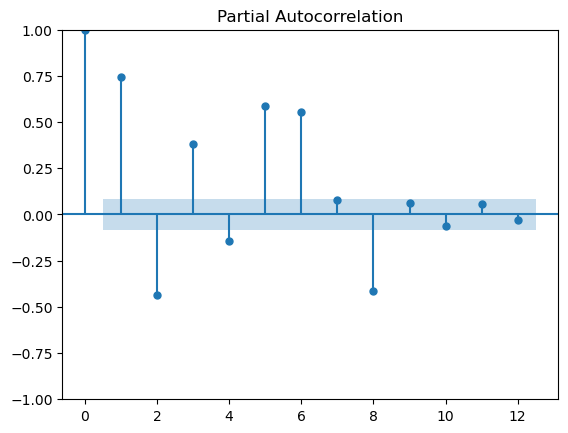

In [ ]:
plt = plot_pacf(series_d, lags=12)

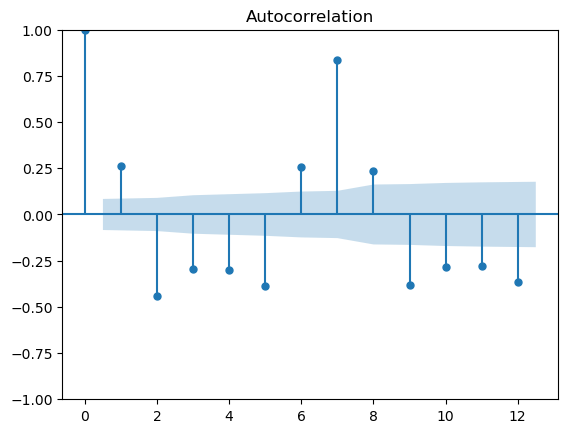

In [ ]:
plt = plot_acf(series_d.diff(periods=1)[4:], lags=12)

In [ ]:
import os
os.listdir('..')

['DCTP']

In [27]:
# heterocedastidade
from src.heteroskedasticity import het_tests

p_value = het_tests(series_d, test='white')
# p_value = het_tests(series, test='breuschpagan')

p_value

ModuleNotFoundError: No module named 'src'

In [ ]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox

?boxcox
# box-cox
transformed_data, best_lambda = boxcox(series_d)

print(transformed_data[:5])
print(series.values[:5])
print(best_lambda)

[189.56836473 215.07176856 235.8360329  240.2014684  242.82540686]
[5159. 4985. 4717. 4356. 4086.]
0.5584579069777834


Signature: boxcox(x, lmbda=None, alpha=None, optimizer=None)
Docstring:
Return a dataset transformed by a Box-Cox power transformation.

Parameters
----------
x : ndarray
    Input array to be transformed.

    If `lmbda` is not None, this is an alias of
    `scipy.special.boxcox`.
    Returns nan if ``x < 0``; returns -inf if ``x == 0 and lmbda < 0``.

    If `lmbda` is None, array must be positive, 1-dimensional, and
    non-constant.

lmbda : scalar, optional
    If `lmbda` is None (default), find the value of `lmbda` that maximizes
    the log-likelihood function and return it as the second output
    argument.

    If `lmbda` is not None, do the transformation for that value.

alpha : float, optional
    If `lmbda` is None and `alpha` is not None (default), return the
    ``100 * (1-alpha)%`` confidence  interval for `lmbda` as the third
    output argument. Must be between 0.0 and 1.0.

    If `lmbda` is not None, `alpha` is ignored.
optimizer : callable, optional
    If `lmbda` 

<Axes: >

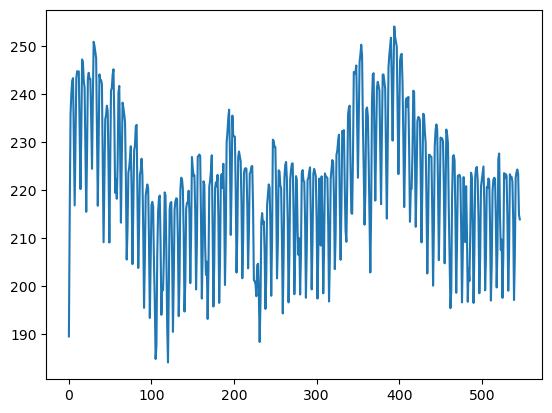

In [ ]:
pd.Series(transformed_data).plot()

## 2) Descrever a estrutura ARIMA que melhor se adequa aos dados

In [ ]:
# divisao entre treino e validacao
from sklearn.model_selection import train_test_split

train, test = train_test_split(series_d, shuffle=False, test_size=0.3)

In [ ]:
train.tail()

datetime
2021-11-29    6020.583333
2021-11-30    5464.458333
2021-12-01    6128.541667
2021-12-02    6729.291667
2021-12-03    6728.875000
Freq: D, Name: load, dtype: float64

In [ ]:
test.head()

datetime
2021-12-04    6654.708333
2021-12-05    6584.875000
2021-12-06    5936.000000
2021-12-07    5329.958333
2021-12-08    5953.333333
Freq: D, Name: load, dtype: float64

In [ ]:
# auto arima
import pmdarima as pm

model = pm.auto_arima(train, m=30, trace=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[30] intercept   : AIC=5404.545, Time=6.28 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=5740.922, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=5647.927, Time=1.20 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=5520.140, Time=1.43 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=5739.000, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[30] intercept   : AIC=5409.692, Time=3.92 sec
 ARIMA(2,1,2)(1,0,0)[30] intercept   : AIC=5420.007, Time=4.70 sec
 ARIMA(2,1,2)(2,0,1)[30] intercept   : AIC=5411.712, Time=16.28 sec
 ARIMA(2,1,2)(1,0,2)[30] intercept   : AIC=5406.031, Time=17.36 sec
 ARIMA(2,1,2)(0,0,0)[30] intercept   : AIC=5438.717, Time=0.53 sec
 ARIMA(2,1,2)(0,0,2)[30] intercept   : AIC=5404.095, Time=13.01 sec
 ARIMA(1,1,2)(0,0,2)[30] intercept   : AIC=5420.474, Time=10.46 sec
 ARIMA(2,1,1)(0,0,2)[30] intercept   : AIC=5483.870, Time=10.18 sec
 ARIMA(3,1,2)(0,0,2)[30] intercept   : AIC=5391.708, Time=15.19 sec
 ARIMA(3,1,2)

In [ ]:
?pm.auto_arima

Signature:
pm.auto_arima(
    y,
    X=None,
    start_p=2,
    d=None,
    start_q=2,
    max_p=5,
    max_d=2,
    max_q=5,
    start_P=1,
    D=None,
    start_Q=1,
    max_P=2,
    max_D=1,
    max_Q=2,
    max_order=5,
    m=1,
    seasonal=True,
    stationary=False,
    information_criterion='aic',
    alpha=0.05,
    test='kpss',
    seasonal_test='ocsb',
    stepwise=True,
    n_jobs=1,
    start_params=None,
    trend=None,
    method='lbfgs',
    maxiter=50,
    offset_test_args=None,
    seasonal_test_args=None,
    suppress_warnings=True,
    error_action='trace',
    trace=False,
    random=False,
    random_state=None,
    n_fits=10,
    return_valid_fits=False,
    out_of_sample_size=0,
    scoring='mse',
    scoring_args=None,
    with_intercept='auto',
    sarimax_kwargs=None,
    **fit_args,
)
Docstring:
Automatically discover the optimal order for an ARIMA model.

The auto-ARIMA process seeks to identify the most optimal
parameters for an ``ARIMA`` model, settling o

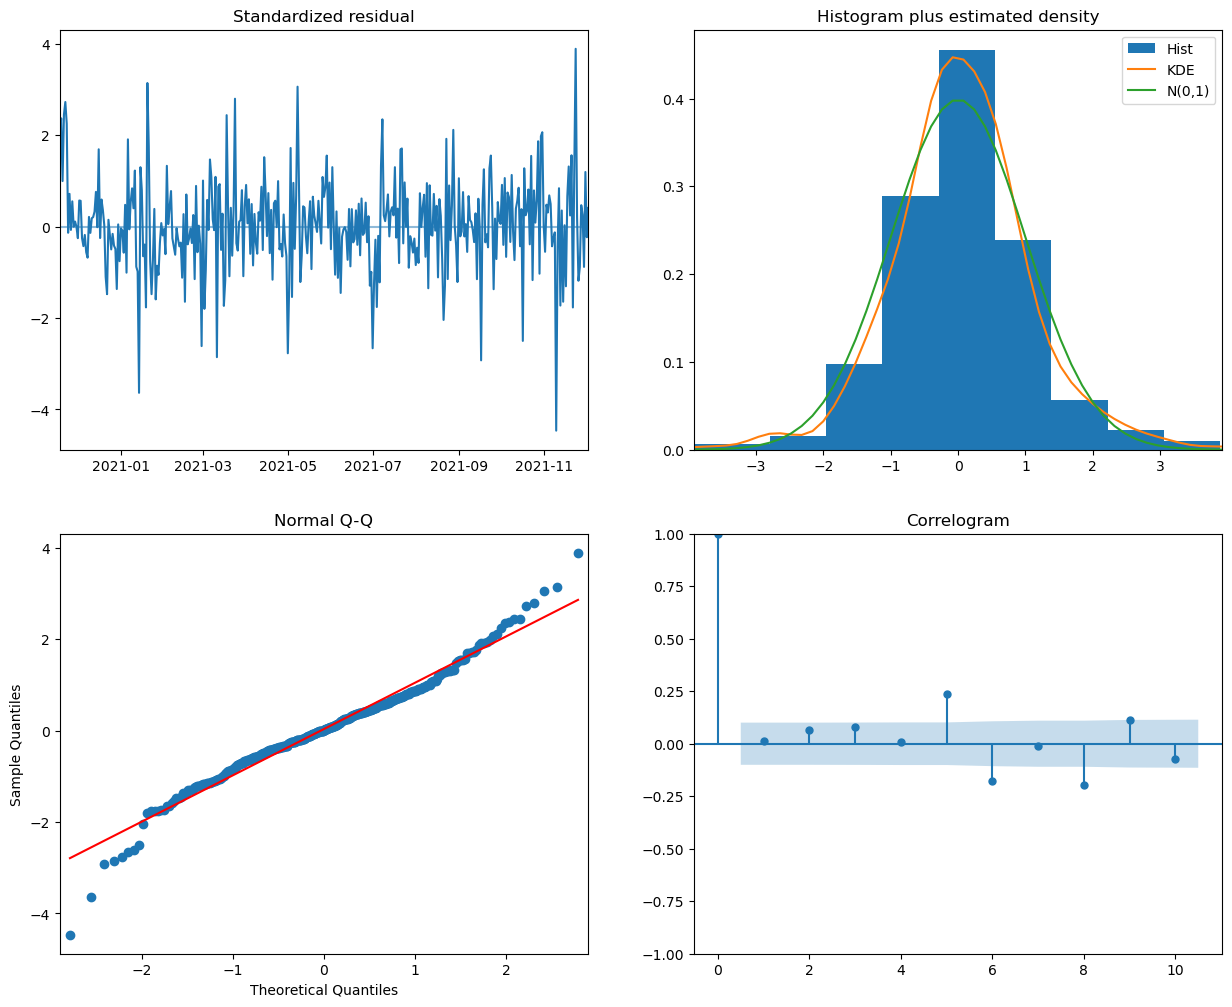

In [ ]:
plot=model.plot_diagnostics(figsize=(15, 12))

In [ ]:
previsoes = model.predict(60)
previsoes

2021-12-04    6685.125869
2021-12-05    6628.850507
2021-12-06    6042.568883
2021-12-07    5654.061147
2021-12-08    6136.645963
2021-12-09    6680.132995
2021-12-10    6683.694133
2021-12-11    6642.938306
2021-12-12    6571.352632
2021-12-13    6086.437986
2021-12-14    5767.691084
2021-12-15    6166.521722
2021-12-16    6628.997854
2021-12-17    6647.246165
2021-12-18    6603.983581
2021-12-19    6526.567871
2021-12-20    6123.545545
2021-12-21    5862.822202
2021-12-22    6192.815044
2021-12-23    6586.342038
2021-12-24    6613.860730
2021-12-25    6570.249375
2021-12-26    6490.898879
2021-12-27    6155.449561
2021-12-28    5942.323666
2021-12-29    6215.929690
2021-12-30    6550.667222
2021-12-31    6583.573055
2022-01-01    6541.040102
2022-01-02    6462.527039
2022-01-03    6182.920626
2022-01-04    6008.820568
2022-01-05    6236.146270
2022-01-06    6520.792743
2022-01-07    6556.292542
2022-01-08    6515.763671
2022-01-09    6439.988473
2022-01-10    6206.606923
2022-01-11  

<Axes: title={'center': 'Previsões com Auto Arima'}, xlabel='datetime'>

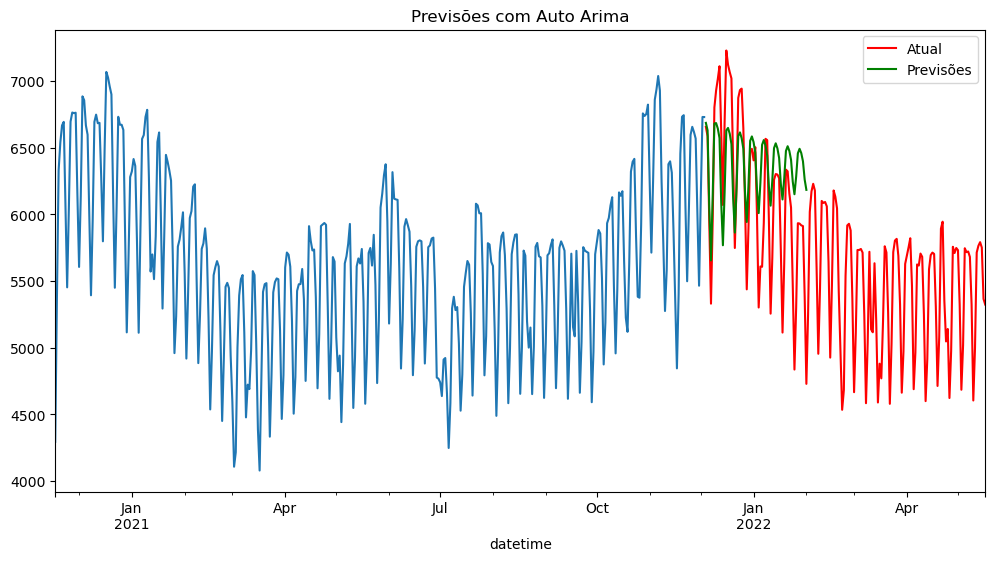

In [ ]:
test = test.rename('Atual')
previsoes = pd.Series(previsoes, index=test.index).rename('Previsões')
ax = train.plot()
ax = test.plot(legend=True,color='red', figsize=(12,6),title='Previsões com Auto Arima')
previsoes.plot(legend=True, color='green')

In [ ]:
# computing the error
from src.error import MASE

err = MASE(train, test, previsoes)

err

ModuleNotFoundError: No module named 'src'

In [ ]:
AR = pm.ARIMA(order=(5,1,2))
MA = pm.ARIMA(order=(0,0,0))
AR.fit(train)

c:\Users\PC\anaconda3\envs\git\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(order=(5, 1, 2))

In [ ]:
AR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  382
Model:               SARIMAX(5, 1, 2)   Log Likelihood               -2584.589
Date:                Thu, 27 Feb 2025   AIC                           5187.178
Time:                        12:03:52   BIC                           5222.664
Sample:                    11-17-2020   HQIC                          5201.258
                         - 12-03-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.7640     14.660      0.189      0.850     -25.968      31.496
ar.L1          0.3136      0.084      3.750      0.000       0.150       0.478
ar.L2         -0.9976      0.067    -14.810      0.000      -1.130      -0.866
ar.L3          0.0765      0.103      0.740      0.459      -0.126       0.279
ar.L4         -0.5459      0.059     -9.198      0.000      -0.662      -0.430
ar.L5         -0.4288      0.071     -6.056      0.000      -0.568      -0.290
ma.L1         -0.1566      0.087     -1.806      0.071      -0.326       0.013
ma.L2          0.4119      0.067      6.168      0.000       0.281       0.543
sigma2      4.386e+04   2454.412     17.871      0.000    3.91e+04    4.87e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                70.36
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               0.95   Skew:                            -0.11
Prob(H) (two-sided):                  0.76   Kurtosis:                         5.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

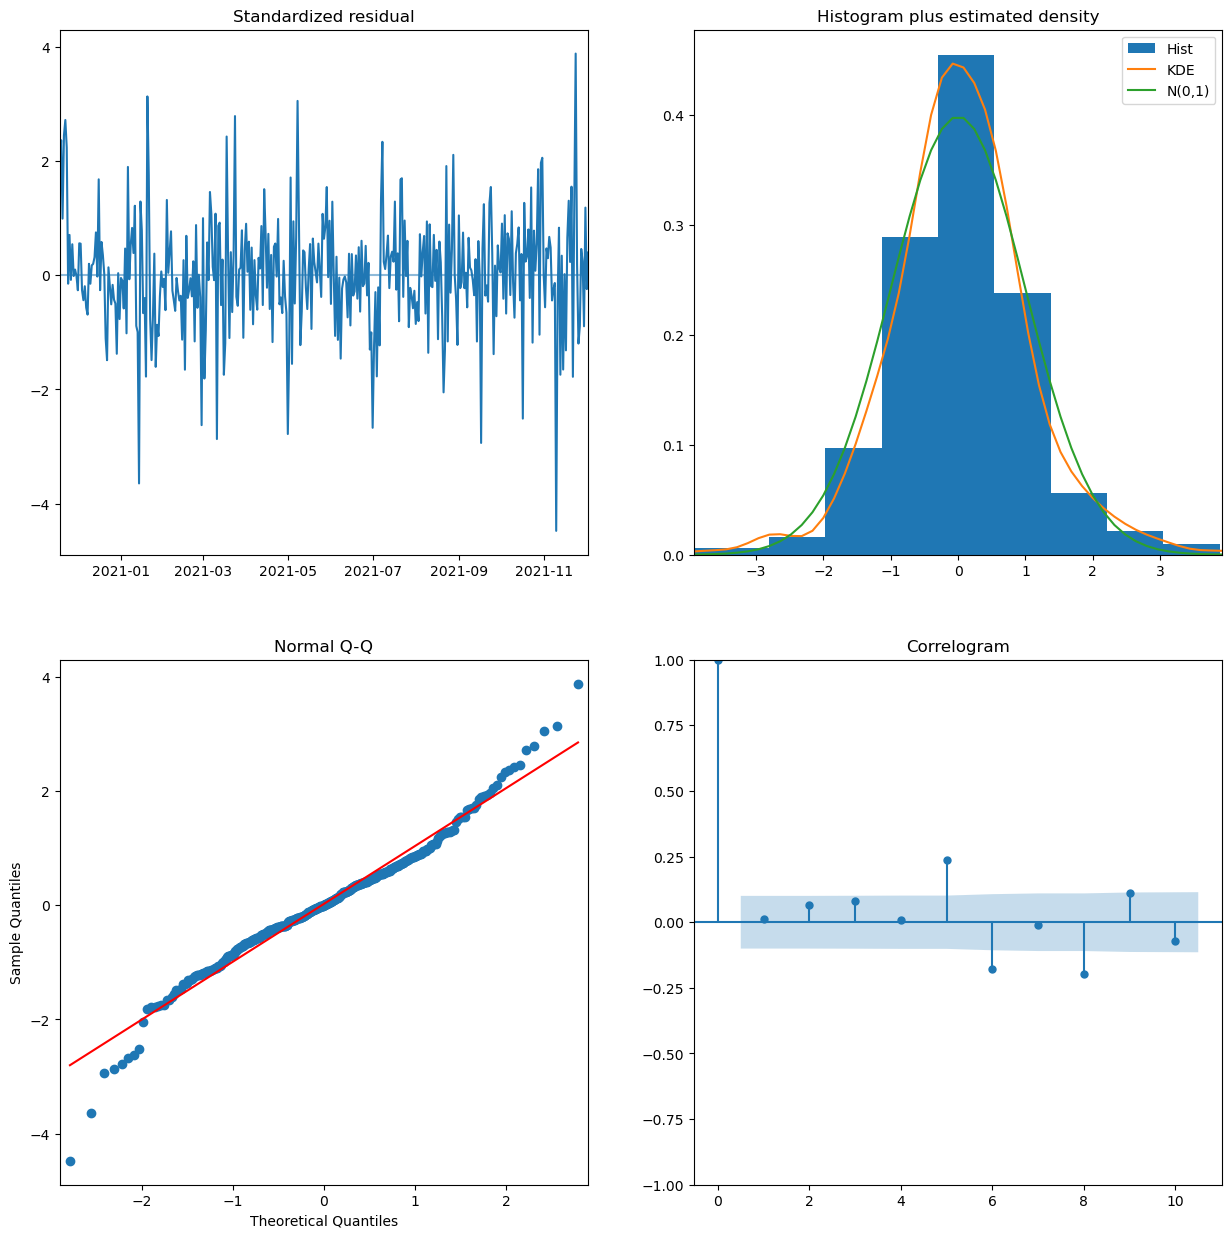

In [ ]:
plot=AR.plot_diagnostics(figsize=(15, 15))

In [ ]:
MA.fit(train)

MA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  382
Model:                        SARIMAX   Log Likelihood               -3008.811
Date:                Thu, 27 Feb 2025   AIC                           6021.622
Time:                        12:03:58   BIC                           6029.513
Sample:                    11-17-2020   HQIC                          6024.752
                         - 12-03-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5629.3341     32.653    172.397      0.000    5565.335    5693.333
sigma2      4.064e+05   3.39e+04     12.004      0.000     3.4e+05    4.73e+05
===================================================================================
Ljung-Box (L1) (Q):                 211.71   Jarque-Bera (JB):                 4.00
Prob(Q):                              0.00   Prob(JB):                         0.14
Heteroskedasticity (H):               0.66   Skew:                             0.06
Prob(H) (two-sided):                  0.02   Kurtosis:                         2.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

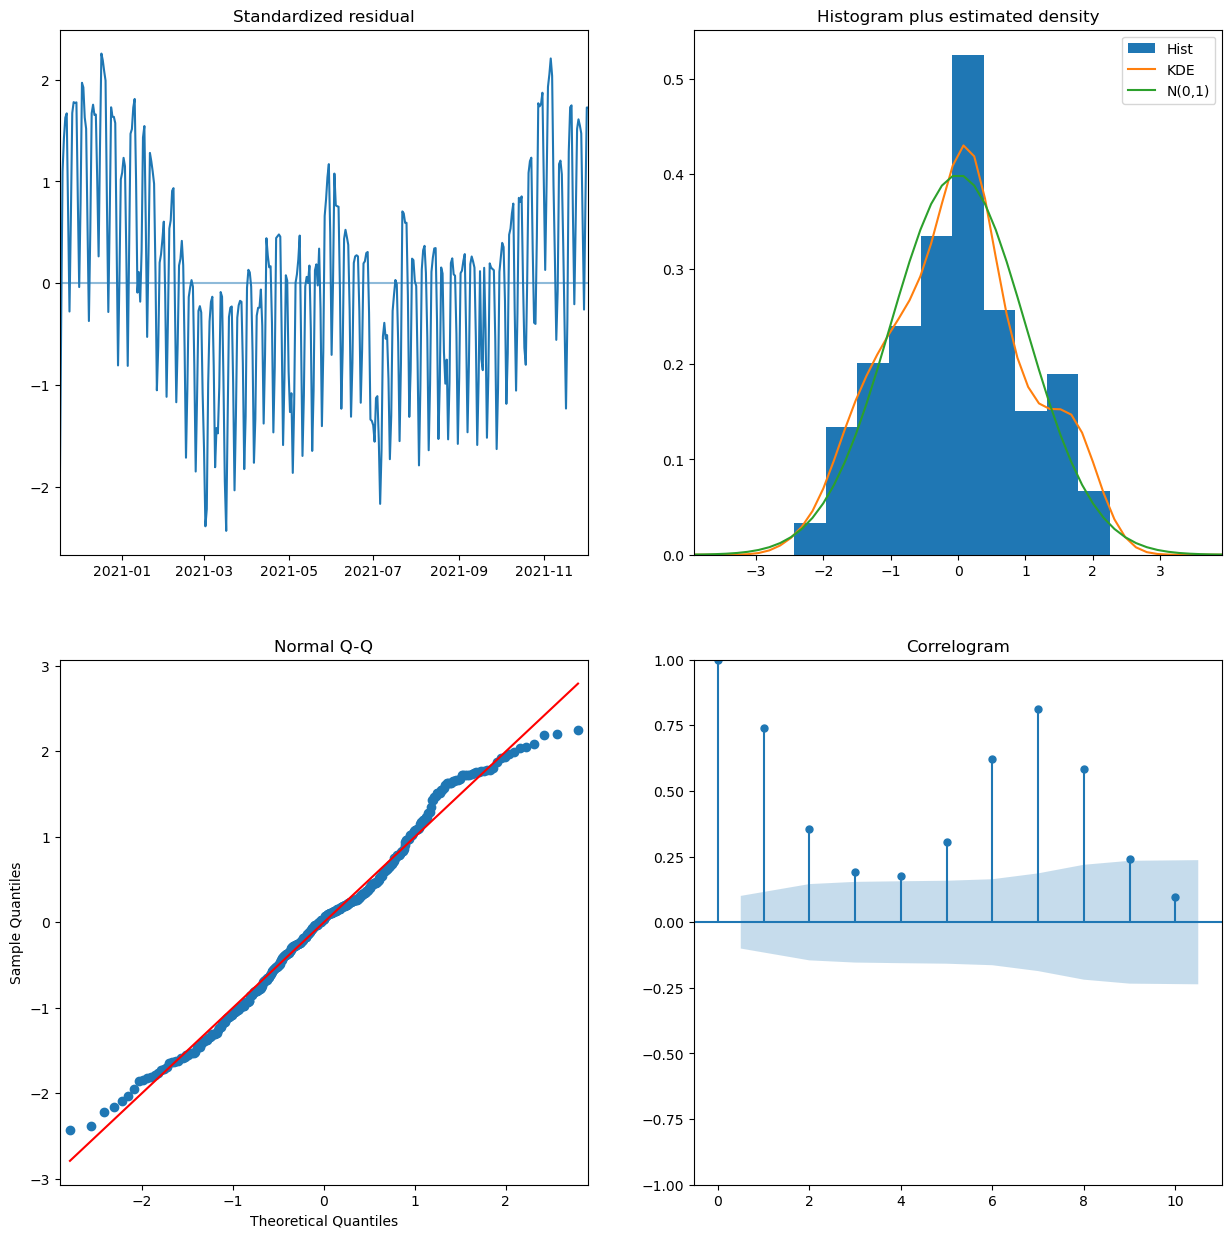

In [ ]:
plot=MA.plot_diagnostics(figsize=(15, 15))

<Axes: title={'center': 'Previsões con ARIMA'}, xlabel='datetime'>

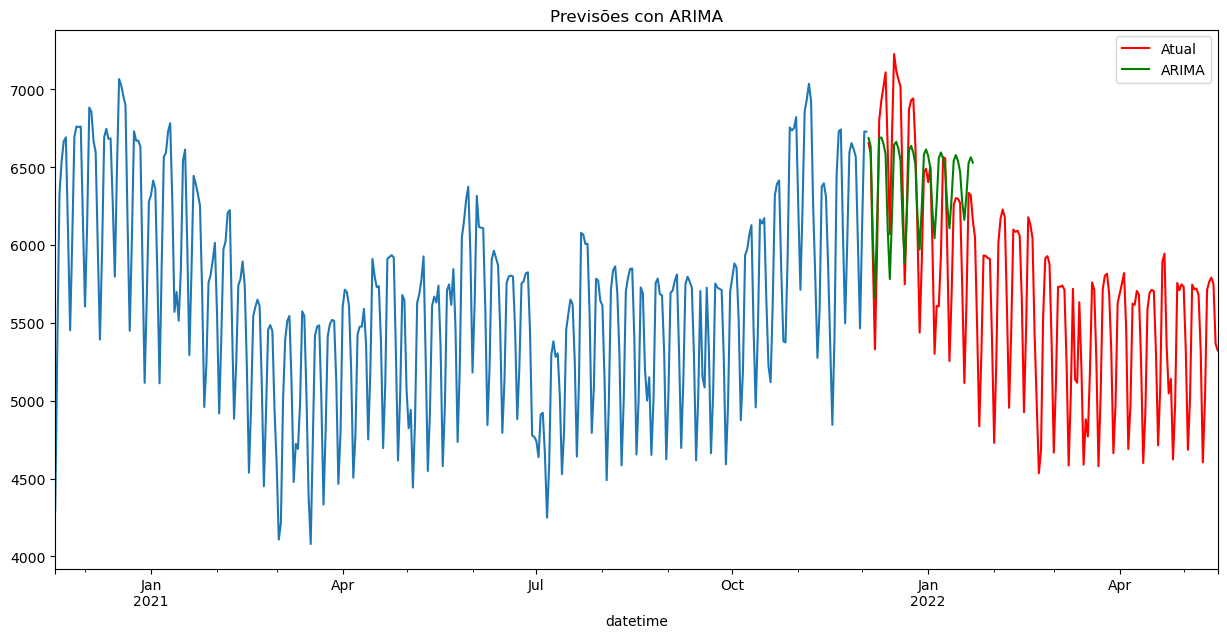

In [ ]:
previsoes = AR.predict(50)
previsoes = pd.Series(previsoes, index=test.index).rename('ARIMA')
ax = train.plot()
ax = test.plot(legend=True,color='red', figsize=(15,7),title='Previsões con ARIMA')
previsoes.plot(legend=True, color='green')

In [ ]:
err = MASE(train, test, previsoes)

err

NameError: name 'MASE' is not defined

# Exponential Smoothing

In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
?ETSModel


ses_model_manual = SimpleExpSmoothing(train, initialization_method="heuristic").fit(smoothing_level=0.5, optimized=False)

ses_model_auto = SimpleExpSmoothing(train, initialization_method="estimated").fit()

Init signature:
ETSModel(
    endog,
    error='add',
    trend=None,
    damped_trend=False,
    seasonal=None,
    seasonal_periods=None,
    initialization_method='estimated',
    initial_level=None,
    initial_trend=None,
    initial_seasonal=None,
    bounds=None,
    dates=None,
    freq=None,
    missing='none',
)
Docstring:     
ETS models.

Parameters
----------
endog : array_like
    The observed time-series process :math:`y`
error : str, optional
    The error model. "add" (default) or "mul".
trend : str or None, optional
    The trend component model. "add", "mul", or None (default).
damped_trend : bool, optional
    Whether or not an included trend component is damped. Default is
    False.
seasonal : str, optional
    The seasonality model. "add", "mul", or None (default).
seasonal_periods : int, optional
    The number of periods in a complete seasonal cycle for seasonal
    (Holt-Winters) models. For example, 4 for quarterly data with an
    annual cycle or 7 for daily

In [ ]:
ses_model_manual.summary()

Dep. Variable:,load,No. Observations:,382
Model:,SimpleExpSmoothing,SSE,97413442.498
Optimized:,False,AIC,4759.539
Trend:,None,BIC,4767.430
Seasonal:,None,AICC,4759.645
Seasonal Periods:,None,Date:,"Thu, 27 Feb 2025"
Box-Cox:,False,Time:,12:04:18
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5000000,alpha,False
initial_level,5331.5944,l.0,False


In [ ]:
ses_model_auto.summary()

Dep. Variable:,load,No. Observations:,382
Model:,SimpleExpSmoothing,SSE,78537820.416
Optimized:,True,AIC,4677.262
Trend:,None,BIC,4685.153
Seasonal:,None,AICC,4677.368
Seasonal Periods:,None,Date:,"Thu, 27 Feb 2025"
Box-Cox:,False,Time:,12:04:21
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9950000,alpha,True
initial_level,5331.5944,l.0,True


In [ ]:
ses_previsoes = ses_model_auto.forecast(50)

print(MASE(train,test,ses_previsoes))

NameError: name 'MASE' is not defined

<Axes: title={'center': 'Previsões com SES'}, xlabel='datetime'>

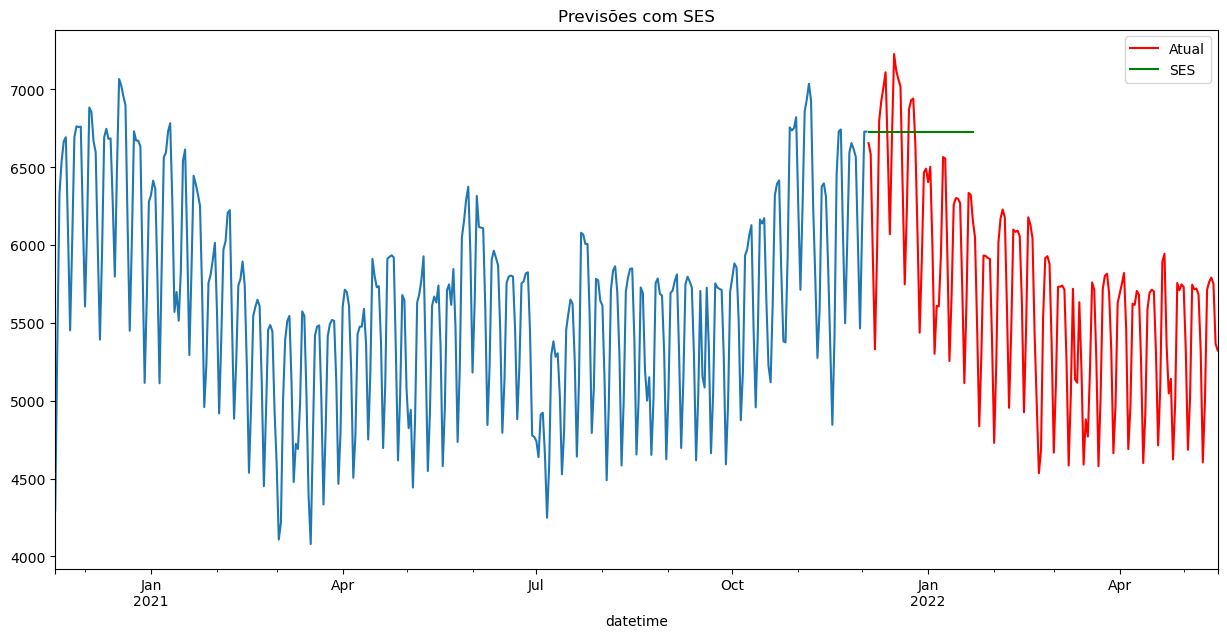

In [ ]:
ses_previsoes = pd.Series(ses_previsoes, index=test.index).rename('SES')
ax = train.plot()
ax = test.plot(legend=True,color='red', figsize=(15,7),title='Previsões com SES')
ses_previsoes.plot(legend=True, color='green')

# Método de Holt

In [ ]:
holt_model1 = Holt(train, initialization_method="estimated").fit(
    smoothing_level=0.8, smoothing_trend=0.2, optimized=False)

forecasts_holt_m1 = holt_model1.forecast(50).rename("Holt's linear trend")

holt_model2 = Holt(train, exponential=True, initialization_method="estimated").fit(
    smoothing_level=0.8, smoothing_trend=0.2, optimized=False)

forecasts_holt_m2 = holt_model2.forecast(50).rename("Exponential trend")

holt_model3 = Holt(train, damped_trend=True, initialization_method="estimated").fit(
    smoothing_level=0.8, smoothing_trend=0.2)

forecasts_holt_m3 = holt_model3.forecast(50).rename("Additive damped trend")

plt.figure(figsize=(12, 8))
plt.plot(test, marker="o", color="black")
(line1,) = plt.plot(forecasts_holt_m1, marker="o", color="blue")
(line2,) = plt.plot(forecasts_holt_m2, marker="o", color="red")
(line3,) = plt.plot(forecasts_holt_m3, marker="o", color="green")
plt.legend([line1, line2, line3], [forecasts_holt_m1.name, forecasts_holt_m2.name, forecasts_holt_m3.name])

TypeError: 'Figure' object is not callable

In [ ]:
# Holt’s Winters Seasonal Exponential Smoothing
es = ExponentialSmoothing(
    train,
    seasonal_periods=4,
    trend="add",
    seasonal="add",
    use_boxcox=False,
    initialization_method="estimated",
).fit()

previsoes_es = es.forecast(50).rename("Holt’s Winters Seasonal Exponential Smoothing")

c:\Users\PC\anaconda3\envs\git\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [ ]:
print(MASE(train,test,previsoes_es))

previsoes_es = previsoes_es.rename('ES')
ax = train.plot()
ax = test.plot(legend=True,color='red', figsize=(12,6),title='Previsões com ES')
previsoes_es.plot(legend=True, color='green')

NameError: name 'MASE' is not defined

In [ ]:
ets = ETSModel(
    train,
    seasonal_periods=30,
    trend="mul",
    seasonal="mul",
    initialization_method="estimated",
).fit()

previsoes_ets = ets.forecast(50).rename("ETS")

In [ ]:
ets.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:                   load   No. Observations:                  382
Model:                       ETS(AMM)   Log Likelihood               -2917.898
Date:                Thu, 27 Feb 2025   AIC                           5907.795
Time:                        12:04:57   BIC                           6049.831
Sample:                    11-17-2020   HQIC                          5964.144
                         - 12-03-2021   Scale                       252476.758
Covariance Type:               approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.1631      0.035      4.626      0.000       0.094       0.232
smoothing_trend      1.631e-05        nan        nan        nan         nan         nan
smoothing_seasonal   8.369e-05        nan        nan        nan         nan         nan
initial_level        6367.1645        nan        nan        nan         nan         nan
initial_trend           1.0000      0.001   1323.737      0.000       0.998       1.001
initial_seasonal.0      0.9863        nan        nan        nan         nan         nan
initial_seasonal.1      0.9750        nan        nan        nan         nan         nan
initial_seasonal.2      1.0001        nan        nan        nan         nan         nan
initial_seasonal.3      1.0074        nan        nan        nan         nan         nan
initial_seasonal.4      1.0126        nan        nan        nan         nan         nan
initial_seasonal.5      1.0125        nan        nan        nan         nan         nan
initial_seasonal.6      1.0215        nan        nan        nan         nan         nan
initial_seasonal.7      1.0153        nan        nan        nan         nan         nan
initial_seasonal.8      1.0094        nan        nan        nan         nan         nan
initial_seasonal.9      0.9970        nan        nan        nan         nan         nan
initial_seasonal.10     0.9899        nan        nan        nan         nan         nan
initial_seasonal.11     0.9914        nan        nan        nan         nan         nan
initial_seasonal.12     0.9919        nan        nan        nan         nan         nan
initial_seasonal.13     0.9938        nan        nan        nan         nan         nan
initial_seasonal.14     1.0003        nan        nan        nan         nan         nan
initial_seasonal.15     0.9976        nan        nan        nan         nan         nan
initial_seasonal.16     0.9934        nan        nan        nan         nan         nan
initial_seasonal.17     0.9901        nan        nan        nan         nan         nan
initial_seasonal.18     0.9915        nan        nan        nan         nan         nan
initial_seasonal.19     1.0144        nan        nan        nan         nan         nan
initial_seasonal.20     1.0262        nan        nan        nan         nan         nan
initial_seasonal.21     1.0118        nan        nan        nan         nan         nan
initial_seasonal.22     1.0044        nan        nan        nan         nan         nan
initial_seasonal.23     0.9885        nan        nan        nan         nan         nan
initial_seasonal.24     0.9726        nan        nan        nan         nan         nan
initial_seasonal.25     0.9842        nan        nan        nan         nan         nan
initial_seasonal.26     1.0067        nan        nan        nan         nan         nan
initial_seasonal.27     1.0135        nan        nan        nan         nan         nan
initial_seasonal.28     0.9983        nan        nan        nan         n

In [ ]:
print(MASE(train,test,previsoes_ets))

previsoes_ets = previsoes_ets.rename('ETS')
ax = train.plot()
ax = test.plot(legend=True,color='red', figsize=(15,7),title='Previsões com ETS')
previsoes_ets.plot(legend=True, color='green')

NameError: name 'MASE' is not defined

In [ ]:
from sktime.forecasting.naive import NaiveForecaster

?NaiveForecaster

naive = NaiveForecaster(strategy='mean')
naive.fit(train)

previsoes_naive = naive.predict(fh=[i for i in range(1,60)])

previsoes_naive

ModuleNotFoundError: No module named 'sktime'

In [ ]:
print(MASE(train,test,previsoes_naive))

previsoes_naive = previsoes_naive.rename('NAIVE')
ax = train.plot()
ax = test.plot(legend=True,color='red', figsize=(15,7),title='Previsoes com Naive')
previsoes_naive.plot(legend=True, color='green')

NameError: name 'MASE' is not defined

# Regressores

In [ ]:
from src.tde import UnivariateTDE

# série para matriz
UnivariateTDE(data=series, k=5, horizon=1)

ModuleNotFoundError: No module named 'src'

In [ ]:
# vários pontos no futuro
UnivariateTDE(data=series, k=5, horizon=5)

NameError: name 'UnivariateTDE' is not defined

In [ ]:
series_df = UnivariateTDE(data=series_day, k=5, horizon=1)
series_df.head()

NameError: name 'UnivariateTDE' is not defined

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# separando as variáveis explicativas
X = series_df.drop('t+1', axis=1)
y = series_df['t+1']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

NameError: name 'series_df' is not defined

In [ ]:
# treinando uma Random Forest
model = RandomForestRegressor()
model.fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [ ]:
# previsoes
previseos = model.predict(X_test)
previsoes[:10]

NameError: name 'X_test' is not defined

In [ ]:
# computing the error
from src.error import MASE

MASE(y_train, y_test, previsoes)

ModuleNotFoundError: No module named 'src'

In [ ]:
y_test = y_test.rename('Atual')
previsoes = pd.Series(previsoes, index=y_test.index).rename('RF')
ax = y_train.plot()
ax = y_test.plot(legend=True,color='red', figsize=(15,7),title='Previsoes com RF')
previsoes.plot(legend=True, color='green')

NameError: name 'y_test' is not defined

In [ ]:
ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)
linear_reg.fit(X_train, y_train)
rf.fit(X_train, y_train)
tree.fit(X_train, y_train)
lgbm.fit(X_train, y_train)

NameError: name 'ridge' is not defined

In [ ]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor

ridge = Ridge()
lasso = Lasso()
linear_reg = LinearRegression()
rf = RandomForestRegressor()
tree = DecisionTreeRegressor()
lgbm = LGBMRegressor()

ModuleNotFoundError: No module named 'lightgbm'

In [ ]:
models = [ridge, lasso, linear_reg, rf, tree, lgbm]
colors = ['yellow','orange','green','grey','black','purple']
previsoes = []
for j,m in enumerate(models):
    print(j)
    pred = m.predict(X_test)
    pred = pd.Series(pred, index=y_test.index).rename(f'Previsao {j}')
    previsoes.append(pred)

NameError: name 'ridge' is not defined

In [ ]:
ax = y_train.plot()
ax = y_test.plot(legend=True,color='red', figsize=(12,6))
for j, pred in enumerate(previsoes):
    pred.plot(legend=True, color=colors[j])

NameError: name 'y_train' is not defined

In [ ]:
for pred in previsoes:
    print(MASE(y_train, y_test, pred))

NameError: name 'MASE' is not defined

In [ ]:
ridge.fit(X_train[1:], y_train.diff()[1:])
lasso.fit(X_train[1:], y_train.diff()[1:])
linear_reg.fit(X_train[1:], y_train.diff()[1:])
rf.fit(X_train[1:], y_train.diff()[1:])
tree.fit(X_train[1:], y_train.diff()[1:])
lgbm.fit(X_train[1:], y_train.diff()[1:])

NameError: name 'ridge' is not defined

In [ ]:
models = [ridge, lasso, linear_reg, rf, tree, lgbm]
for m in models:
    pred = m.predict(X_test)
    print(MASE(y_train.diff()[1:], y_test.diff()[1:], pred[1:]))

NameError: name 'ridge' is not defined

## 3) Avaliar diferentes métodos de aprendizagem máquina com validação cruzada.

VALIDAÇÃO CRUZADA

<Axes: xlabel='datetime'>

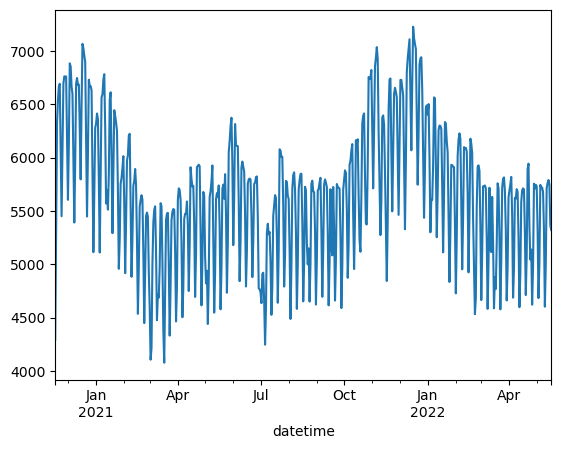

In [ ]:
series_d.plot()

In [ ]:
from src.tde import UnivariateTDE

ModuleNotFoundError: No module named 'src'

In [ ]:
# prever o próximo valor com base nos 6 anteriores
series_tde = UnivariateTDE(series_d.diff(), horizon=1, k=6)
series_tde.head()

NameError: name 'UnivariateTDE' is not defined

In [ ]:
# separar variáveis explicativas da variável objetivo
X = series_tde.drop('t+1', axis=1)
y = series_tde['t+1']

NameError: name 'series_tde' is not defined

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

NameError: name 'X' is not defined

In [ ]:
X_train.head()

NameError: name 'X_train' is not defined

In [ ]:
y_train.head()

NameError: name 'y_train' is not defined

ESTIMAÇÃO DE DESEMPENHO

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
cv = TimeSeriesSplit(n_splits=5)

cv_err = []
for tr_idx, ts_idx in cv.split(X_train, y_train):
    print('Indices de Treino:')
    print(tr_idx[-5:])
    X_tr = X_train.values[tr_idx]
    y_tr = y_train.values[tr_idx]

    X_vl = X_train.values[ts_idx]
    y_vl = y_train.values[ts_idx]

    print('Treinando o modelo')
    model = Ridge()

    model.fit(X_tr, y_tr)
    print('Fazendo previsões')
    pred = model.predict(X_vl)

    print('Computando o erro')
    err = mean_absolute_error(y_vl, pred)
    cv_err.append(err)

    
print(cv_err)

NameError: name 'X_train' is not defined

In [ ]:
# erro estimado em validação cruzada
print(f'erro medio é: {np.mean(cv_err)}')

erro medio é: nan


c:\Users\PC\anaconda3\envs\git\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\PC\anaconda3\envs\git\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
# erro que obtemos no teste
model = Ridge()
model.fit(X_train, y_train)
pred_test = model.predict(X_test)
err_test = mean_absolute_error(y_test, pred_test)
print(f'Erro do teste é: {err_test}')

NameError: name 'X_train' is not defined

In [ ]:
model_list = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'RandomForestRegressor': RandomForestRegressor(n_estimators=10),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'KNeighborsRegressor': KNeighborsRegressor(),
}

from sklearn.model_selection import cross_val_score

In [ ]:
err_by_method = {}
for method in model_list:
    print(f'Running model: {method}')
    cv_error = cross_val_score(model_list[method],
                               X_train,
                               y_train,
                               cv=cv,
                               scoring='neg_mean_absolute_error')

    err_by_method[method] = -np.mean(cv_error)

Running model: Ridge


NameError: name 'X_train' is not defined

In [ ]:
pd.Series(err_by_method).plot.bar()

TypeError: no numeric data to plot

In [ ]:
from pprint import pprint
pprint(err_by_method)

{}


Seleção de Parâmetros

In [ ]:
from sklearn.model_selection import GridSearchCV

?GridSearchCV

parameters = {'weights': ['uniform', 'distance'],
              'n_neighbors': [1, 5, 10]}

Init signature:
GridSearchCV(
    estimator,
    param_grid,
    *,
    scoring=None,
    n_jobs=None,
    refit=True,
    cv=None,
    verbose=0,
    pre_dispatch='2*n_jobs',
    error_score=nan,
    return_train_score=False,
)
Docstring:     
Exhaustive search over specified parameter values for an estimator.

Important members are fit, predict.

GridSearchCV implements a "fit" and a "score" method.
It also implements "score_samples", "predict", "predict_proba",
"decision_function", "transform" and "inverse_transform" if they are
implemented in the estimator used.

The parameters of the estimator used to apply these methods are optimized
by cross-validated grid-search over a parameter grid.

Read more in the :ref:`User Guide <grid_search>`.

Parameters
----------
estimator : estimator object
    This is assumed to implement the scikit-learn estimator interface.
    Either estimator needs to provide a ``score`` function,
    or ``scoring`` must be passed.

param_grid : dict or list of

In [ ]:
model = KNeighborsRegressor()
cv = TimeSeriesSplit(n_splits=5)
​
grid_search = GridSearchCV(estimator=model,
                           param_grid=parameters,
                           cv=cv, 
                           refit=True)
​

SyntaxError: invalid non-printable character U+200B (3093926812.py, line 3)

In [ ]:
grid_search.fit(X_train, y_train)

NameError: name 'grid_search' is not defined

In [ ]:
grid_search.best_estimator_

NameError: name 'grid_search' is not defined

In [ ]:
pred_test_best = grid_search.predict(X_test)
err_test = mean_absolute_error(y_test, pred_test_best)
print(f'Test error is: {err_test}')

NameError: name 'grid_search' is not defined